In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from my_scripts.data_cleaning import (feature_deletion, feature_transform_notNan, non_numerical_features, feature_ordinalEncoding)

# 1. Collect Insights

**Basic Data Preprocessing:**    
A few pre-processing functions have been encoded into the file `data_cleaning.py`. The description of each function can be found in the aforementioned file.    
The basic idea is: 
1. Delete the useless features for prediction (i.e features with all Nans, features that are associated to a randomly given ID ...). 
2. Transform some features such as phone number of email address. Someone's phone number is not usefull in its essence, however, the fact of knowning that the client was willing to give his phone number might be.
3. Check the type of all features: the algorithms that are used required numerical data, hence, some `object` features need to be encoded. Ordinal encoding is used. A special attention is given to dates: only the year's data is kept. 
4. Check that there are no undefined values. If so replace them by their median or mean (or use another method). 
5. Some algorithm respond badly to outliers (especially Ridge regression). Hence, some methods were prepared to remove outliers. However, one might know that there exist a wide range of outlier removal algorithms, hence which method to use is considered as a hyperparameter of the model, and can be tuned in later sections of the notebook. 

Features Kept: ['MailingPostalCode' 'Phone' 'Email' 'HasOptedOutOfEmail'
 'HasOptedOutOfFax' 'DoNotCall' 'Age__c' 'Bike_Type_Interest__c'
 'Bikes_Purchased__c' 'Homeowner__c' 'Income_Range__c'
 'Joined_Group_Rides__c' 'Occupation__c' 'Service_Visits__c'
 'Signed_Up_For_Races__c' 'Total_Spent__c' 'VeloStars_Member__c'
 'First_Purchase__c']


<AxesSubplot:>

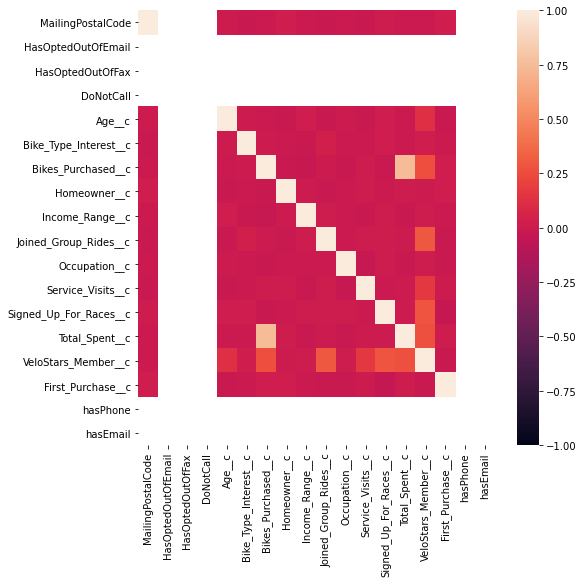

In [4]:
df = pd.read_csv("Contact.csv")

# delete useless columns
columns_to_delete = ['Id', 'IsDeleted', 'AccountId', 'FirstName', 'LastName','MailingStreet', 'MailingCity', 'MailingState','OwnerId', 'CreatedDate', 'CreatedById', 'LastModifiedDate', 'LastModifiedById', 'SystemModstamp', 'CleanStatus', 'IndividualId']
df = feature_deletion(df, columns_to_delete)

# reduce information contained in phone and email 
df = feature_transform_notNan(df, "Phone", "hasPhone")
df = feature_transform_notNan(df, "Email", "hasEmail")

# ordinal encoding of the categorical features 
df, mapping_bike_type = feature_ordinalEncoding(df, 'Bike_Type_Interest__c')
df, mapping_income_range = feature_ordinalEncoding(df, 'Income_Range__c')
df, mapping_occupation = feature_ordinalEncoding(df, 'Occupation__c')

# convert date string to a data object and only keep the year 
df["First_Purchase__c"] = pd.to_datetime(df["First_Purchase__c"])
df["First_Purchase__c"] = df["First_Purchase__c"].apply(lambda x: x.year)

# we take a look at the correlation matrix to remove any potential correlated features
plt.figure(figsize=(8, 8))
sns.heatmap(df.corr(),vmin=-1.0, vmax=1.0, xticklabels=df.columns, yticklabels=df.columns)

In [5]:
# drop useless columns revealed by the auto-correlation heat-map
df = df.drop(columns=['HasOptedOutOfEmail', 'HasOptedOutOfFax', 'DoNotCall', 'hasPhone',  'hasEmail'])

In [6]:
df.to_csv("Contact_Clean.csv")

**First Insights:**   
Before starting the analysis, to mimic SalesForce example, only some contacts are kept: 
- contacts that have a VeloStars membership
- contacts that first bought a bike after 2015 and that do not have a VeloStars membership
These two observations will form our training/testing set. However, before training, one should take a look at the data to answer a few questions: 
- are the two classes well balanced ? 
- is there significant differences between the two classes (i.e elements are 

<ipython-input-8-2bf8ab284821>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  control = df[df['VeloStars_Member__c'] == 0][df['First_Purchase__c'] >= 2015]
C:\Users\pmansat\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\pmansat\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Percenage of people with membership card: 46.10%


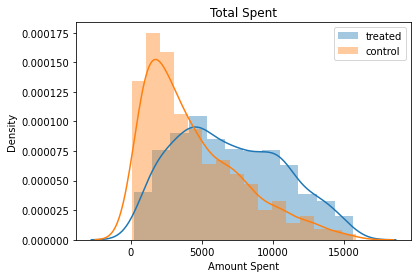

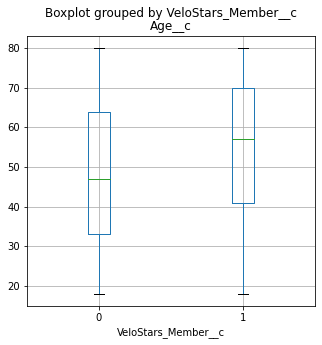

In [8]:
# gather the insights 
# seperate the two populations (VeloStars members and non-Velostars members)
treated = df[df['VeloStars_Member__c'] == 1]
control = df[df['VeloStars_Member__c'] == 0][df['First_Purchase__c'] >= 2015]

# check the balance of each classes 
print("Percenage of people with membership card: " + "{:.02f}".format(treated.shape[0]/(treated.shape[0] + control.shape[0]) *100) + "%")

# membership and total spent have a high positive correlation, we should investigate if the difference is important
ax = sns.distplot(treated['Total_Spent__c'], hist=True, label='treated');
ax = sns.distplot(control['Total_Spent__c'], hist=True, label='control')
ax.set(title='Total Spent',xlabel='Amount Spent', ylabel='Density')
plt.legend()
plt.show()

# age seemed to be highly correlated to membership, we investigate if the data corroborates such a difference 
df.boxplot(by='VeloStars_Member__c', column='Age__c', figsize = [5, 5], grid=True)
plt.show()